In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = 'data'  
output_dir = 'organized_dataset'

In [3]:

for split in ['train', 'validate', 'test']:
    for class_name in ['metal', 'organic', 'plastic']:
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

images = []
labels = []

In [4]:

for class_name in ['metal', 'organic', 'plastic']:
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_dir):
        print(f"Warning: Directory for class '{class_name}' not found. Skipping...")
        continue

    for img in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img)
        if os.path.isfile(img_path):
            images.append(img_path)
            labels.append(class_name)

print(f"Total images found: {len(images)}")

if len(images) == 0:
    raise ValueError("No images found in the dataset. Please check the dataset structure.")


Total images found: 2309


In [5]:

train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [6]:

def move_images(image_list, labels_list, split):
    for img, label in zip(image_list, labels_list):
        dest_dir = os.path.join(output_dir, split, label)
        shutil.copy(img, dest_dir)

move_images(train_images, train_labels, 'train')
move_images(val_images, val_labels, 'validation')
move_images(test_images, test_labels, 'test')

print("✅ Data has been organized successfully.")
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

✅ Data has been organized successfully.
Train set: 1616 images
Validation set: 346 images
Test set: 347 images


In [7]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import os

augmenter = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

dataset_dir = 'organized_dataset/train/'
augmented_dir = '/augmented_dataset/train/'

os.makedirs(augmented_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    augmented_class_path = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Load the image
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generate new images
        i = 0
        for batch in augmenter.flow(img_array, batch_size=1, save_to_dir=augmented_class_path,
                                    save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= 5:
                break

print("✅ Augmented images saved successfully!")

✅ Augmented images saved successfully!


In [8]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = 'organized_dataset/train'
validation_dir = os.path.join(output_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)



test_dir = os.path.join(output_dir, 'test')
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1616 images belonging to 3 classes.
Found 346 images belonging to 3 classes.
Found 347 images belonging to 3 classes.


In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
for layer in base_model.layers[-20:]:
    layer.trainable = True



model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

C:\Users\Sandamal\.conda\envs\general_project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 544ms/step - accuracy: 0.3994 - loss: 8.4426 - val_accuracy: 0.7254 - val_loss: 7.3285
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - accuracy: 0.5505 - loss: 7.6799 - val_accuracy: 0.8208 - val_loss: 7.0718
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.6647 - loss: 7.4068 - val_accuracy: 0.8439 - val_loss: 6.9189
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 486ms/step - accuracy: 0.7092 - loss: 7.1909 - val_accuracy: 0.8757 - val_loss: 6.7815
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.7240 - loss: 7.1053 - val_accuracy: 0.8786 - val_loss: 6.6746
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 479ms/step - accuracy: 0.7662 - loss: 6.8800 - val_accuracy: 0.8873 - val_loss: 6.5839
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 481ms/step - accuracy: 0.7919 - loss: 6.8103 - val_accuracy: 0.9162 - val_loss: 6.4859
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - accuracy: 0.8084 - loss: 6.6818 - val_accu

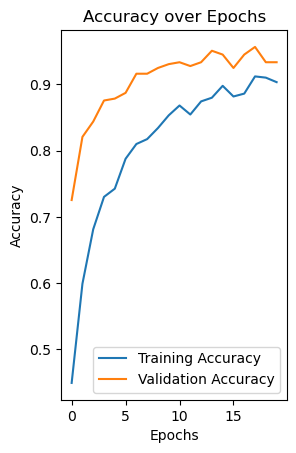

In [11]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

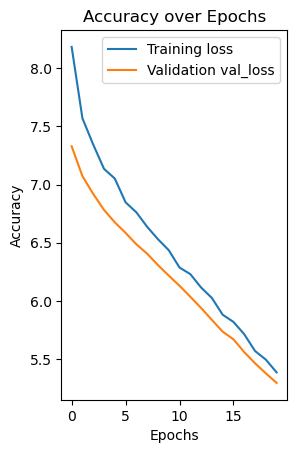

In [12]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation val_loss')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9633 - loss: 5.2146
Test Accuracy: 95.68%


In [14]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

threshold = 0.10

if train_acc - val_acc > threshold:
    print("⚠️ The model is OVERFITTING! Consider applying regularization techniques.")
else:
    print("✅ The model is NOT overfitting.")

Final Training Accuracy: 90.35%
Final Validation Accuracy: 93.35%
✅ The model is NOT overfitting.


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step


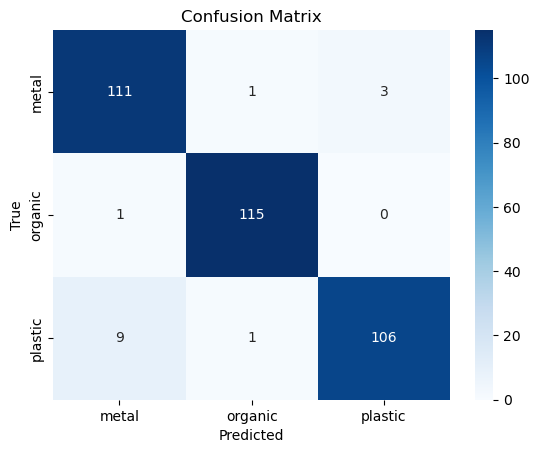

              precision    recall  f1-score   support

       metal       0.92      0.97      0.94       115
     organic       0.98      0.99      0.99       116
     plastic       0.97      0.91      0.94       116

    accuracy                           0.96       347
   macro avg       0.96      0.96      0.96       347
weighted avg       0.96      0.96      0.96       347



In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

In [16]:

model.save("my_model.h5")


In [18]:
from tensorflow.keras.models import load_model

# Replace with your model filename
model = load_model("my_model.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [29]:
from PIL import Image
import numpy as np

img_path = "3.jpeg"
# Resize to 96x96 because the model expects that
img = Image.open(img_path).resize((96, 96))
img_array = np.array(img) / 255.0  # Normalize if needed
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
pred = model.predict(img_array)
class_names = ['plastic', 'organic', 'metal']  # Your classes
predicted_class = class_names[np.argmax(pred)]
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: organic
